In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/urbansound8k


In [3]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Define windowing functions
def apply_window(signal, window_type, n_fft):
    if window_type == "hann":
        window = np.hanning(n_fft)
    elif window_type == "hamming":
        window = np.hamming(n_fft)
    elif window_type == "rectangular":
        window = np.ones(n_fft)
    else:
        raise ValueError("Unsupported window type")
    return signal * window

# Generate spectrogram with STFT and a specific window
def generate_spectrogram(signal, sr, n_fft, hop_length, window_type):
    window = apply_window(np.ones(n_fft), window_type, n_fft)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window=window)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return spectrogram

# Plot spectrogram
def plot_spectrogram(spectrogram, sr, hop_length, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        spectrogram, sr=sr, hop_length=hop_length, x_axis="time", y_axis="log"
    )
    plt.colorbar(format="%.2f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Feature extraction
def extract_features(signal, sr, n_fft, hop_length, window_types):
    features = []
    for window_type in window_types:
        spectrogram = generate_spectrogram(signal, sr, n_fft, hop_length, window_type)
        features.append(np.mean(spectrogram, axis=1))  # Mean across time
    return np.concatenate(features)


In [4]:
# Load UrbanSound8K dataset and process
#DATA_PATH = "UrbanSound8K/audio"
DATA_PATH = path
n_fft = 2048
hop_length = 512
window_types = ["hann", "hamming", "rectangular"]

X = []
y = []

print("Processing audio files...")
for subdir, _, files in os.walk(DATA_PATH):
    for file in tqdm(files):
        if file.endswith(".wav"):
            filepath = os.path.join(subdir, file)
            label = int(file.split("-")[1])  # Extract class label from file name
            signal, sr = librosa.load(filepath, sr=None)
            features = extract_features(signal, sr, n_fft, hop_length, window_types)
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM classifier
print("Training SVM classifier...")
clf = SVC(kernel="linear", random_state=42)
clf.fit(X_train, y_train)

# Evaluate classifier
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")



Processing audio files...


100%|██████████| 823/823 [00:32<00:00, 24.98it/s]


Training SVM classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       178
           1       0.91      0.77      0.83        88
           2       0.71      0.80      0.75       210
           3       0.80      0.73      0.76       204
           4       0.88      0.88      0.88       204
           5       0.92      0.94      0.93       196
           6       0.81      0.81      0.81        84
           7       0.97      0.92      0.94       191
           8       0.88      0.91      0.89       180
           9       0.83      0.73      0.77       212

    accuracy                           0.85      1747
   macro avg       0.85      0.85      0.85      1747
weighted avg       0.85      0.85      0.85      1747

Accuracy: 0.85


Visualizing sample spectrograms...


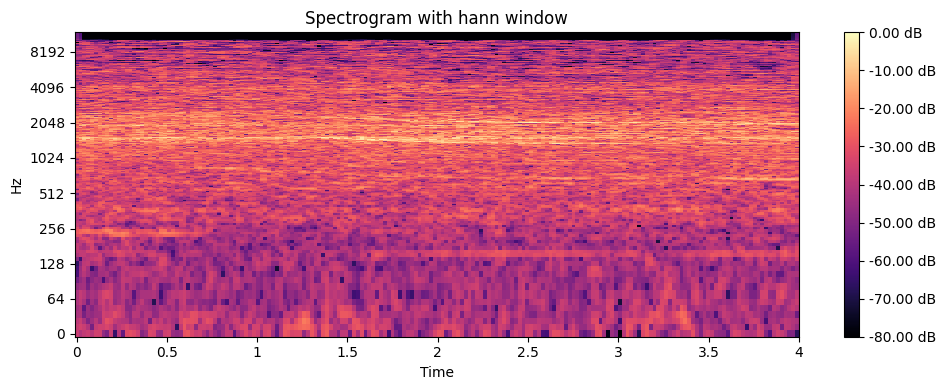

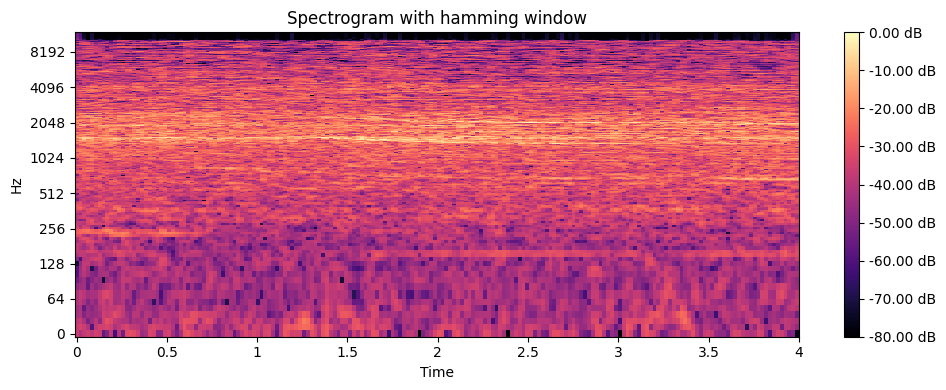

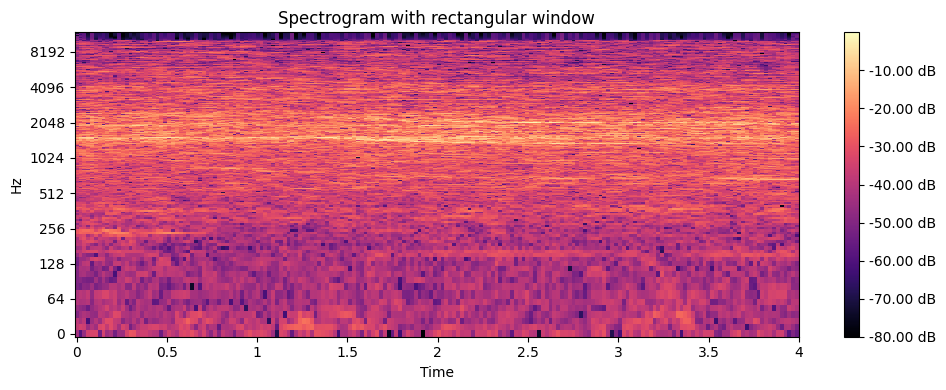

In [6]:
# Analyze and plot spectrograms
#print("Visualizing sample spectrograms...")
#example_signal, sr = librosa.load(os.path.join(DATA_PATH, "fold1", os.listdir(os.path.join(DATA_PATH, "fold1"))[0]), sr=None)
# Analyze and plot spectrograms
print("Visualizing sample spectrograms...")
# Get a list of files in the fold1 directory
files_in_fold1 = os.listdir(os.path.join(DATA_PATH, "fold1"))
# Filter out the '.DS_Store' file if it exists
audio_files_in_fold1 = [f for f in files_in_fold1 if f.endswith(".wav")]
# Load the first valid audio file
example_signal, sr = librosa.load(os.path.join(DATA_PATH, "fold1", audio_files_in_fold1[0]), sr=None)


for window_type in window_types:
    spectrogram = generate_spectrogram(example_signal, sr, n_fft, hop_length, window_type)
    plot_spectrogram(spectrogram, sr, hop_length, f"Spectrogram with {window_type} window")
